In [115]:
import time
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq, newton
from tqdm.notebook import tqdm
import scipy

### Load Data

In [116]:
from libsvm.svmutil import *

def libsvm_to_numpy(filename: str, num_features: int) -> Tuple[np.array, np.array]:
    labels, features = svm_read_problem(filename)
    data_matrix = np.zeros((len(features), num_features))

    for i in range(len(features)):
        for j in features[i].keys():
            data_matrix[i, j - 1] = features[i][j]

    labels = np.array(labels)
    labels[labels == -1] = 0
    labels[labels == 2] = 0

    return data_matrix, labels


In [130]:
X, y = libsvm_to_numpy('../data/a9a', 123)
d = 123
N = X.shape[0]

### Lipschitz

In [118]:
def grad_lipschitz(data_matrix: np.array) -> float:
    """

    max_sigma^2 is the largest eigenvalue of X'X.
    The first-order Lipschitz constant is bounded above by
    1/(4N) sqrt(lambda(X'X)), which is proportional to the
    induced two-norm of X'X.
    :param data_matrix:
    :return: upper bound of the first-order Lipschitz constant.
    """

    max_sigma = scipy.linalg.svdvals(data_matrix)[0]
    return (1 / (4 * data_matrix.shape[0])) * max_sigma * max_sigma

In [119]:
def hessian_lipschitz(data_matrix: np.array) -> float:
    """
    max_sigma^2 is the largest eigenvalue of X'X.
    The second-order Lipschitz constant is bounded above by
    1/(3*sqrt(6)) * max(norm(x_i)) * sqrt(lambda(X'X)), which
    is proportional to the induced two-norm of X'X.
    :param data_matrix:
    :return: upper bound of the second-order Lipschitz constant.
    """

    max_sigma = scipy.linalg.svdvals(data_matrix)[0]
    return 1/(6*np.sqrt(3)) * np.max(np.linalg.norm(data_matrix, axis=0)) * max_sigma * max_sigma

In [208]:
def hessian_lipschitz2(data_matrix: np.array) -> float:
    """
    max_sigma^2 is the largest eigenvalue of X'X.
    The second-order Lipschitz constant is bounded above by
    1/(3*sqrt(6)) * max(norm(x_i)) * sqrt(lambda(X'X)), which
    is proportional to the induced two-norm of X'X.
    :param data_matrix:
    :return: upper bound of the second-order Lipschitz constant.
    """

    l_constant = 0.0
    for i in range(X.shape[0]):
        for j in range(d):
            for k in range(d):
                for l in range(d):
                    l_constant += abs(X[j, i]*X[k, i]*X[l, i])
                    
    l_constant *= (1/X.shape[0])
    l_constant *= (0.5 - np.sqrt(3) / 6)
    
    return l_constant

### Helper Functions

In [120]:
def sigma(x):
    return 1/(1+np.exp(-x))

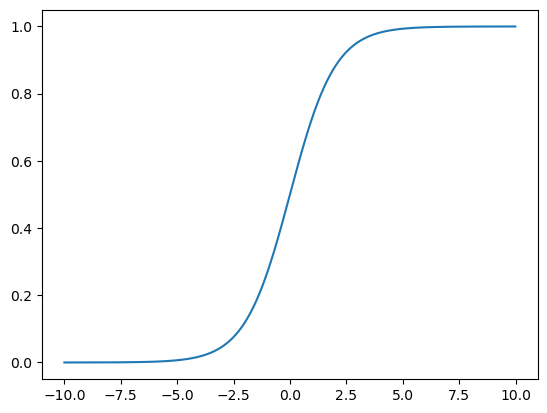

In [121]:
x = np.arange(-10, 10, 0.01)
y = sigma(x)
plt.plot(x, y)

In [146]:
def L(y: np.array, y_hat: np.array) -> float:
    loss = -(y*np.log(y_hat+1e-8)).sum()
    return loss/X.shape[0]

In [147]:
def y_calc(theta: np.array, X: np.array) -> float:
    weights = theta[:-1]
    b = theta[-1]
    return sigma(X@weights.T + b)

### Generate Training Data

In [153]:
d = 100 # dimension of feature space
N = 100 # number of data points
X = 2*(np.random.rand(N, d)-0.5) # data matrix (features are columns) randomly generated with uniform distribution [-1, 1]
weights = np.random.rand(d)
b = np.random.rand()
theta = np.append(weights, b)

In [154]:
y = sigma(X@weights.T + b) > 0.5  # generate labels
y = y.astype(float)

### Gradient and Hessian

In [155]:
def gradient(theta: np.array) -> np.array:
    y_hat = y_calc(theta, X)
    
    w_grads = X.T @ (y_hat - y)
    b_grad = (y_hat - y).sum()
    
    return np.append(w_grads, b_grad)/X.shape[0]

In [156]:
def hessian(theta: np.array) -> np.array:
    ws = theta[:-1]
    bs = theta[-1]
    H = np.zeros((len(ws)+1, len(ws)+1), dtype=np.float64)
    
    sigma_lookup = sigma(X@ws + bs) * (1 - sigma(X@ws + bs))
    
    for j in range(len(ws)):
        for k in range(j, len(ws)):
            H[j, k] = np.sum(X[:, j] * X[:, k] * sigma_lookup)
            H[k, j] = H[j, k]
            
    for j in range(len(ws)):
        H[j, len(ws)] = np.sum(X[:, j] * sigma_lookup)
        H[len(ws), j] = H[j, len(ws)]
        
    H[len(ws), len(ws)] = sigma_lookup.sum()
    
    return H/X.shape[0]

### First-Order with Quadratic L2 Regularization

In [157]:
alpha = 1/grad_lipschitz(X)
# alpha = 10
theta_hat = np.random.rand(d+1)
orig_theta_hat = np.copy(theta_hat)
num_iters = 1000
loss_o1_q = []

In [158]:
for _ in tqdm(range(num_iters)):
    y_hat = y_calc(theta_hat, X)
    loss_o1_q.append(L(y, y_hat))
    theta_hat = theta_hat - alpha*gradient(theta_hat)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'Iterations')

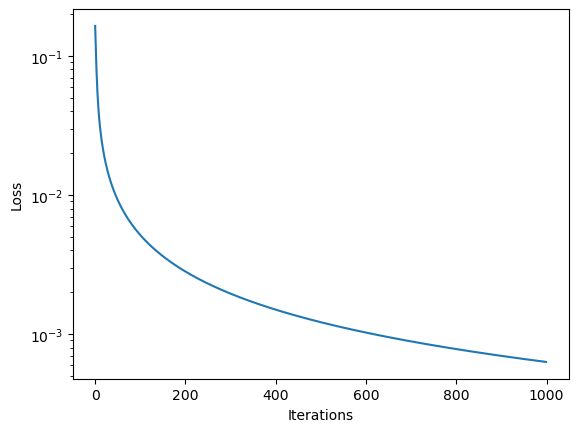

In [159]:
x_axis = np.arange(num_iters)
plt.semilogy(x_axis, loss_o1_q)
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [160]:
loss_o1_q[:10]

[0.16454758584871573,
 0.12646479248664363,
 0.0988025027678778,
 0.07859062372597597,
 0.06462807876681109,
 0.05497170948828194,
 0.048014534425738935,
 0.04277037474922264,
 0.03866674198985095,
 0.03535996520587939]

### Second-Order with Cubic L2 Regularization (Slow Version)

In [204]:
alpha = 0.01
theta_hat = np.copy(orig_theta_hat)
loss_o2_c = []

In [205]:
def f_reg(theta: np.array, *args) -> float:
    grads = gradient(theta_hat)
    H = hessian(theta_hat)
    theta_orig = args[0]
    
    return grads + H@(theta-theta_orig) + (1/alpha)*np.sqrt(np.linalg.norm(theta-theta_orig)) * (theta-theta_orig)

In [206]:
start_time = time.time()
for _ in tqdm(range(10)):
    y_hat = sigma(X@theta_hat[0:-1].T + theta_hat[-1])
    loss_o2_c.append(L(y, y_hat))
    theta_hat = fsolve(f_reg, np.zeros(d+1), args=(theta_hat))
    
print(f"Took {time.time() - start_time} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Took 30.706305503845215 seconds.


Text(0.5, 0, 'Iterations')

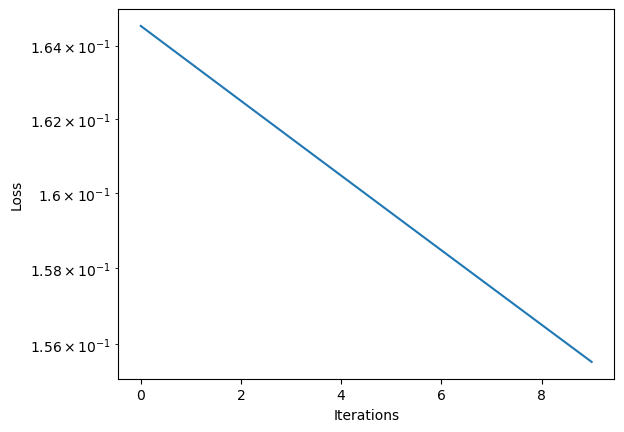

In [207]:
x_axis = np.arange(num_iters)
plt.semilogy(loss_o2_c)
plt.ylabel("Loss")
plt.xlabel("Iterations")

### Second-Order with Cubic L2 Regularization (Fast Version)

In [195]:
M = hessian_lipschitz(X)  # not a very tight upper bound
theta_hat = np.copy(orig_theta_hat)
loss_o2_c_fast = []

In [196]:
M

75.74441110293475

In [197]:
def opt_subproblem(r: float, *args) -> float:
    grads = args[0]
    H = args[1]
    Lambda = args[2]
    U = args[3]
    g_bar = args[4]
        
    result = 0
    for i in range(H.shape[0]):
        result += g_bar[i]**2 / (Lambda[i] + M*r/2)**2
    
    return result - r*r

In [198]:
start_time = time.time()
for _ in tqdm(range(num_iters)):
    y_hat = sigma(X@theta_hat[0:-1].T + theta_hat[-1])
    loss_o2_c_fast.append(L(y, y_hat))
    
    grads = gradient(theta_hat)
    H = hessian(theta_hat)
    Lambda, U = np.linalg.eig(H)
    g_bar = U.T@grads
    r_star = newton(opt_subproblem, 0.5, args=(grads, H, Lambda, U, g_bar))
    if r_star < 0:
        raise Exception("r < 0!")
    h = -U@np.linalg.inv(np.diag(Lambda) + M*r_star/2*np.eye(H.shape[0]))@g_bar
    theta_hat += np.real(h)
    
print(f"Took {time.time() - start_time} seconds.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Took 19.692923307418823 seconds.


Text(0.5, 0, 'Iterations')

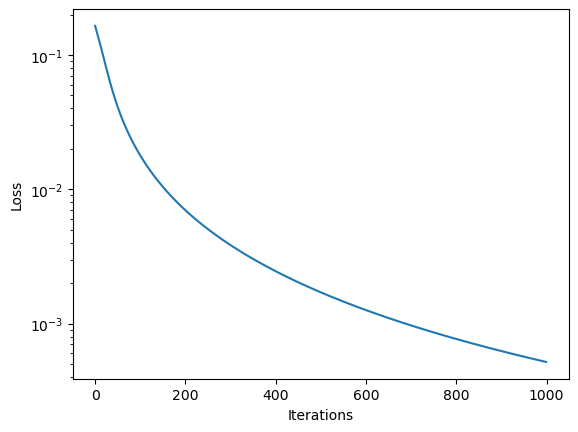

In [199]:
x_axis = np.arange(num_iters)
plt.semilogy(loss_o2_c_fast)
plt.ylabel("Loss")
plt.xlabel("Iterations")

### Fast Adaptive Method

In [263]:
M_vals = np.logspace(-3, 3, 25)
loss_o2_c_fast_m_test = np.zeros((num_iters, 25))

In [264]:
for i in range(len(M_vals)):
    theta_hat = np.copy(orig_theta_hat)
    start_time = time.time()
    M = M_vals[i]
    print(f"Testing M={M}")
    for j in tqdm(range(num_iters)):
        y_hat = sigma(X@theta_hat[0:-1].T + theta_hat[-1])
        loss_o2_c_fast_m_test[j, i] = L(y, y_hat)

        grads = gradient(theta_hat)
        H = hessian(theta_hat)
        Lambda, U = np.linalg.eig(H)
        g_bar = U.T@grads
        r_star = newton(opt_subproblem, 0.5, args=(grads, H, Lambda, U, g_bar))
        if r_star < 0:
            raise Exception("r < 0!")
        h = -U@np.linalg.inv(np.diag(Lambda) + M*r_star/2*np.eye(H.shape[0]))@g_bar
        theta_hat += np.real(h)

    print(f"Took {time.time() - start_time} seconds.")

Testing M=0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 30.341512203216553 seconds.
Testing M=0.0017782794100389228


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 29.31359314918518 seconds.
Testing M=0.0031622776601683794


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 29.67081928253174 seconds.
Testing M=0.005623413251903491


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 29.010083198547363 seconds.
Testing M=0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 29.076429843902588 seconds.
Testing M=0.01778279410038923


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 27.511757373809814 seconds.
Testing M=0.03162277660168379


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.48643708229065 seconds.
Testing M=0.05623413251903491


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 27.358502626419067 seconds.
Testing M=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 25.96401596069336 seconds.
Testing M=0.1778279410038923


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.038008213043213 seconds.
Testing M=0.31622776601683794


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.327006340026855 seconds.
Testing M=0.5623413251903491


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 25.7021906375885 seconds.
Testing M=1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 25.997005701065063 seconds.
Testing M=1.7782794100389228


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 24.9033362865448 seconds.
Testing M=3.1622776601683795


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.759340286254883 seconds.
Testing M=5.623413251903491


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.000662326812744 seconds.
Testing M=10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 25.657567739486694 seconds.
Testing M=17.78279410038923


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 26.808890104293823 seconds.
Testing M=31.622776601683793


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 27.55456280708313 seconds.
Testing M=56.23413251903491


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 28.460512399673462 seconds.
Testing M=100.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 27.204878091812134 seconds.
Testing M=177.82794100389228


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 28.162776470184326 seconds.
Testing M=316.22776601683796


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 28.511013984680176 seconds.
Testing M=562.341325190349


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 27.180505752563477 seconds.
Testing M=1000.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Took 28.4322669506073 seconds.


In [265]:
loss_o2_c_fast_m_test

array([[1.64547586e-01, 1.64547586e-01, 1.64547586e-01, ...,
        1.64547586e-01, 1.64547586e-01, 1.64547586e-01],
       [5.19184533e-02, 5.09573316e-02, 5.06123809e-02, ...,
        1.62311904e-01, 1.62868035e-01, 1.63286403e-01],
       [1.63764708e-02, 1.65010185e-02, 1.69886896e-02, ...,
        1.60107010e-01, 1.61205942e-01, 1.62035099e-01],
       ...,
       [3.03469011e-09, 9.97754183e-09, 2.23040089e-08, ...,
        1.77721937e-03, 2.82018031e-03, 4.38242594e-03],
       [3.01673098e-09, 9.94564183e-09, 2.22473749e-08, ...,
        1.77429702e-03, 2.81574653e-03, 4.37585434e-03],
       [2.99882593e-09, 9.91383787e-09, 2.21909114e-08, ...,
        1.77138198e-03, 2.81132342e-03, 4.36929810e-03]])

Text(0.5, 0, 'Iterations')

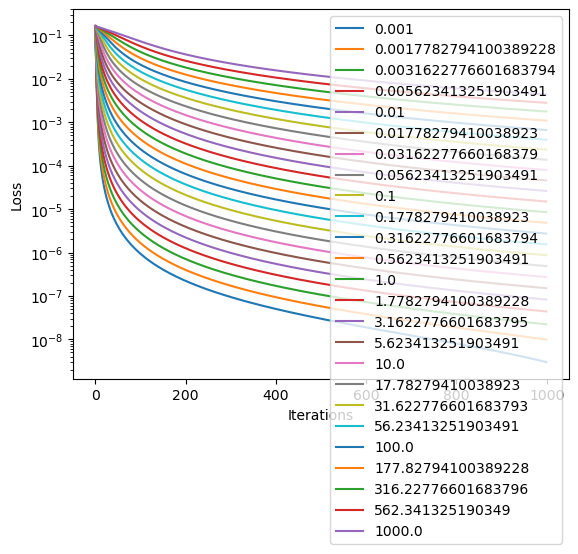

In [266]:
x_axis = np.arange(num_iters)
plt.semilogy(loss_o2_c_fast_m_test)
plt.legend(M_vals)
plt.ylabel("Loss")
plt.xlabel("Iterations")

### Comparison

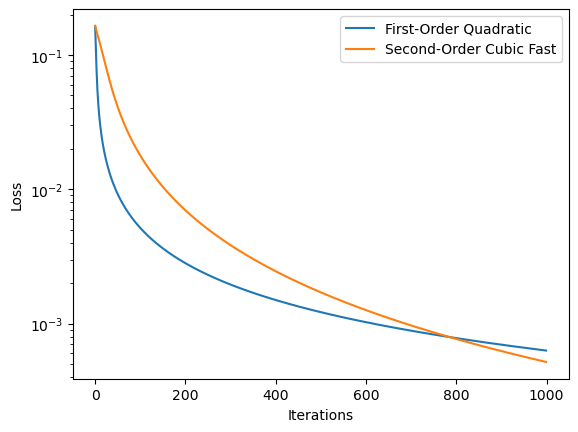

In [200]:
x_axis = np.arange(num_iters)
plt.semilogy(x_axis, loss_o1_q)
# plt.semilogy(x_axis, loss_o2_q)
# plt.semilogy(x_axis, loss_o2_c)
plt.semilogy(x_axis, loss_o2_c_fast)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend(["First-Order Quadratic", "Second-Order Cubic Fast"])